## Sentiment analysis project

##### Author: Mantas Bilaisis 

The aim of this notebook is to perform sentiment analysis for [tweets about US airlines](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).
The tweets in this dataset are grouped into three categories: positive, neutral and negative. The main tasks of this project are:
   - To prepare text data for analysis.
   - To perform sentiment analysis with Vader and TextBlob lexicons.
   - To perform sentiment analysis with machine learning classification algorithms.
   - To compare results achieved using lexicons and ML algorithms.

### Part 1. Using Vader and TextBlob

In [46]:
# Importing relevant libraries
import pandas as pd
import re
import nltk
import spacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [15]:
# Reading data and printing first 5 rows
df = pd.read_csv('Tweets.csv', encoding='utf-8')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [16]:
# Only airline_Sentiment and text attributes will be used in further analysis
df = df[['airline_sentiment', 'text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [19]:
# Cleaning unwanted symbols and account usernames from text

def clean_tweet(text):
    text = ''.join(re.findall(r'[^.,!?#"]+', text))
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)", " ", text).split())
    return text

In [20]:
df['cleaned_text'] = df['text'].apply(clean_tweet)
df.head()

,airline_sentiment,text,cleaned_text
0,neutral,@VirginAmerica What @dhepburn said.,What said
1,positive,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...
2,neutral,@VirginAmerica I didn't today... Must mean I n...,I didn't today Must mean I need to take anothe...
3,negative,@VirginAmerica it's really aggressive to blast...,it's really aggressive to blast obnoxious ente...
4,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it


In [21]:
# Checking if there are any empty tweers after cleaning, or missing sentiments
df.isnull().sum()

airline_sentiment    0
text                 0
cleaned_text         0
dtype: int64

In [22]:
# Checking how many entries there are in each category
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

There are more negative tweets, however the classes don't seem to be too imbalanced. Higher count of negative tweets in the datset can be linked to the fact that people who are unsatissfied with the services are more likely to leave reviews online.

#### Vader lexicon

In [23]:
# Importing Vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\manta\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [24]:
# Calculating polarity scores for each tweet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df['scores'] = df['cleaned_text'].apply(lambda text: sid.polarity_scores(text))
df.head()

,airline_sentiment,text,cleaned_text,scores
0,neutral,@VirginAmerica What @dhepburn said.,What said,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,positive,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,neutral,@VirginAmerica I didn't today... Must mean I n...,I didn't today Must mean I need to take anothe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,negative,@VirginAmerica it's really aggressive to blast...,it's really aggressive to blast obnoxious ente...,"{'neg': 0.236, 'neu': 0.628, 'pos': 0.135, 'co..."
4,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,"{'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'comp..."


In [25]:
# Extracting compound polarity score
df['compound'] = df['scores'].apply(lambda txt: txt['compound'])
df.head()

,airline_sentiment,text,cleaned_text,scores,compound
0,neutral,@VirginAmerica What @dhepburn said.,What said,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,positive,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,neutral,@VirginAmerica I didn't today... Must mean I n...,I didn't today Must mean I need to take anothe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,negative,@VirginAmerica it's really aggressive to blast...,it's really aggressive to blast obnoxious ente...,"{'neg': 0.236, 'neu': 0.628, 'pos': 0.135, 'co...",-0.2716
4,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,"{'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'comp...",-0.5829


In [26]:
# Airline tweets are classified into three categories based on a rule that scores from interval
# [0.05, 1] are classified as positive
# [-1, -0.05] classified as negative
# (-0.05, 0.05) classified as neutral
def polarity_score(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

In [27]:
df['comp_score'] = df['compound'].apply(lambda val: polarity_score(val))
df.head()

,airline_sentiment,text,cleaned_text,scores,compound,comp_score
0,neutral,@VirginAmerica What @dhepburn said.,What said,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,positive,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
2,neutral,@VirginAmerica I didn't today... Must mean I n...,I didn't today Must mean I need to take anothe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3,negative,@VirginAmerica it's really aggressive to blast...,it's really aggressive to blast obnoxious ente...,"{'neg': 0.236, 'neu': 0.628, 'pos': 0.135, 'co...",-0.2716,negative
4,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,"{'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'comp...",-0.5829,negative


In [28]:
accuracy = accuracy_score(df['airline_sentiment'], df['comp_score'])
precision = precision_score(df['airline_sentiment'], df['comp_score'], average='weighted')
recall = recall_score(df['airline_sentiment'], df['comp_score'], average='weighted')
f1 = f1_score(df['airline_sentiment'], df['comp_score'], average='weighted')

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics)

print(metrics_df)

      Metric     Value
0   Accuracy  0.549112
1  Precision  0.700983
2     Recall  0.549112
3   F1 Score  0.571680


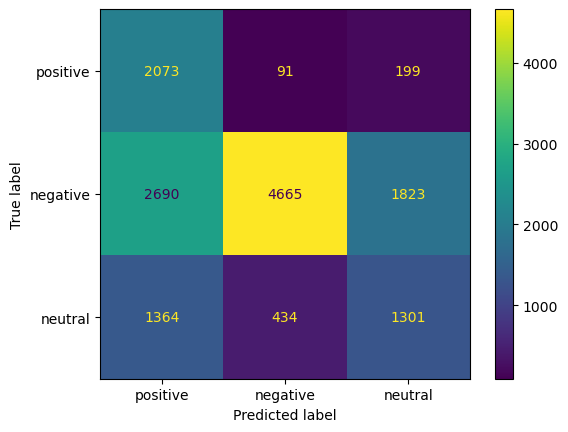

In [31]:
cm = confusion_matrix(df['airline_sentiment'], df['comp_score'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['positive', 'negative', 'neutral'])
disp.plot();

Total classification accuracy with Vader lexicon is not good (only 54.9 %). Using this lexicon positive tweets were classified most accurately. Negative tweets were often mixed with both positive and neutral, while neutral tweets were most often deemed to be positive.

#### TextBlob

In [32]:
# Importing TextBlob lexicon
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [33]:
# Calculating polarity score

def calculate_polarity(text):
    doc = nlp(text)
    polarity = doc._.polarity
    return polarity

df['polarity_textblob'] = df['cleaned_text'].apply(calculate_polarity)

In [34]:
df.head()

,airline_sentiment,text,cleaned_text,scores,compound,comp_score,polarity_textblob
0,neutral,@VirginAmerica What @dhepburn said.,What said,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.00000
1,positive,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.00000
2,neutral,@VirginAmerica I didn't today... Must mean I n...,I didn't today Must mean I need to take anothe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,-0.31250
3,negative,@VirginAmerica it's really aggressive to blast...,it's really aggressive to blast obnoxious ente...,"{'neg': 0.236, 'neu': 0.628, 'pos': 0.135, 'co...",-0.2716,negative,0.00625
4,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,"{'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'comp...",-0.5829,negative,-0.35000


In [35]:
df['sent_textblob'] = df['polarity_textblob'].apply(lambda val: polarity_score(val))
df.head()

,airline_sentiment,text,cleaned_text,scores,compound,comp_score,polarity_textblob,sent_textblob
0,neutral,@VirginAmerica What @dhepburn said.,What said,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.00000,neutral
1,positive,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,0.00000,neutral
2,neutral,@VirginAmerica I didn't today... Must mean I n...,I didn't today Must mean I need to take anothe...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,-0.31250,negative
3,negative,@VirginAmerica it's really aggressive to blast...,it's really aggressive to blast obnoxious ente...,"{'neg': 0.236, 'neu': 0.628, 'pos': 0.135, 'co...",-0.2716,negative,0.00625,neutral
4,negative,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,"{'neg': 0.351, 'neu': 0.649, 'pos': 0.0, 'comp...",-0.5829,negative,-0.35000,negative


In [37]:
accuracy = accuracy_score(df['airline_sentiment'], df['sent_textblob'])
precision = precision_score(df['airline_sentiment'], df['sent_textblob'], average='weighted')
recall = recall_score(df['airline_sentiment'], df['sent_textblob'], average='weighted')
f1 = f1_score(df['airline_sentiment'], df['sent_textblob'], average='weighted')

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics)

print(metrics_df)

      Metric     Value
0   Accuracy  0.452186
1  Precision  0.674639
2     Recall  0.452186
3   F1 Score  0.460871


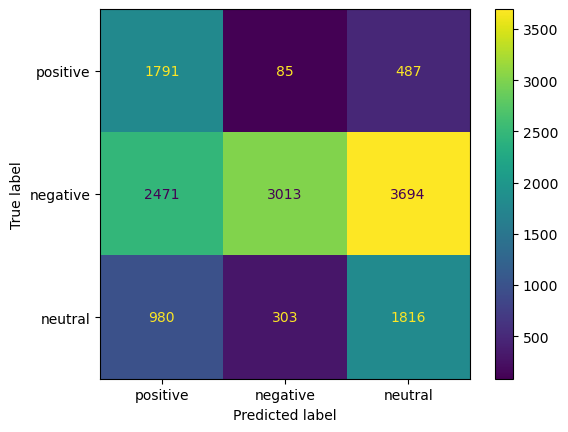

In [38]:
cm = confusion_matrix(df['airline_sentiment'], df['sent_textblob'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['positive', 'negative', 'neutral'])
disp.plot();

Classification accuracy is even worse with TextBlob. Here positive tweets were again classified most accurately, while a lot of the negative tweets were deemed to be neutral or positive.

### Part 2. Using ML classification algorithms

To be able to feed text into classification algorithms it was first vectorized. Bag of Words vectorizer (CountVectorizer from sklearn) was chosen for this project. Logistic regression, k-nearest neighbor and support vector classifiers were compared. 

In [39]:
X = df['cleaned_text']
y = df['airline_sentiment']

# splitting dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, stratify=y)

# vectorizing text
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

X_train_countvect = vect.transform(X_train)
X_test_countvect = vect.transform(X_test)

#### Logistic regression

In [40]:
# fitting logistic regression model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_countvect, y_train)

LogisticRegression(max_iter=10000)

In [43]:
# evaluating 

y_pred = lr.predict(X_test_countvect)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

    negative       0.86      0.89      0.87      1835
     neutral       0.63      0.61      0.62       620
    positive       0.76      0.68      0.72       473

    accuracy                           0.80      2928
   macro avg       0.75      0.73      0.74      2928
weighted avg       0.79      0.80      0.80      2928



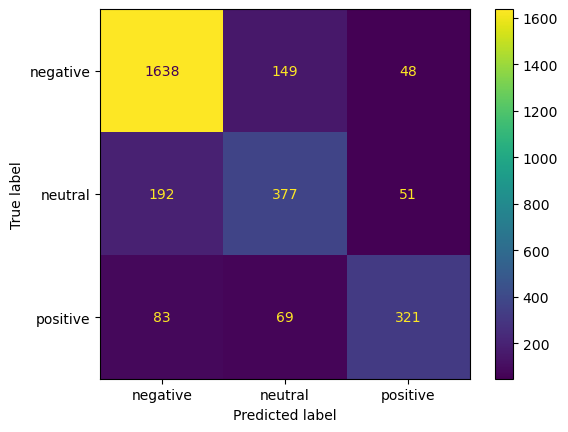

In [44]:
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lr.classes_)
disp.plot();

Logistic regression with bag of words vectorization showed much better results than lexicons. However, it's important to note that classification accuracy here is presented only on test dataset whereas sentiment classification results obtained with lexicons are presented for the entire dataset as lexicons do not require model training.

#### K-Nearest Neighbors

In [48]:
#searching for best hyperparameters with grid search
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

par_grid = {'n_neighbors': [5, 10, 20, 50],
            'weights':['uniform', 'distance']
           }

grid_search = GridSearchCV(estimator=KNeighborsClassifier(), 
                           param_grid=par_grid, 
                           scoring='recall_micro',
                          cv=5)
grid_search.fit(X_train_countvect, y_train)
best_knn = grid_search.best_estimator_
print(best_knn.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [49]:
#predicting on test data
y_pred = best_knn.predict(X_test_countvect)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

    negative       0.81      0.54      0.65      1835
     neutral       0.31      0.57      0.40       620
    positive       0.45      0.53      0.49       473

    accuracy                           0.54      2928
   macro avg       0.52      0.55      0.51      2928
weighted avg       0.64      0.54      0.57      2928



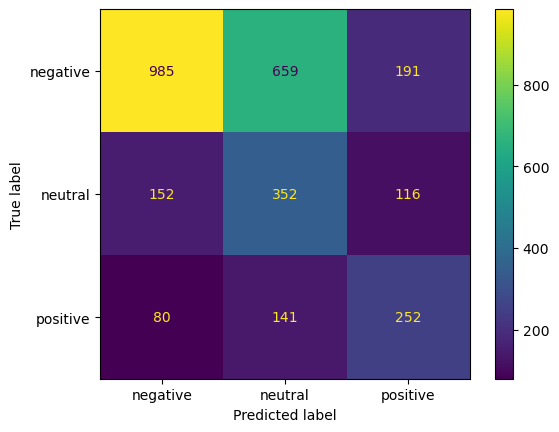

In [50]:
cm = confusion_matrix(y_test, y_pred, labels=best_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_knn.classes_)
disp.plot();

KNN model showed worse results compared to logistic regression. It mostly struggled in distinguishing positive and negative tweets from neutral.

#### Support Vector Classifier

In [51]:
#selecting kernel for the model
from sklearn.svm import SVC

par_grid = {'kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(estimator=SVC(random_state=0), 
                           param_grid=par_grid,
                          cv=5)
grid_search.fit(X_train_countvect, y_train)
best_svc = grid_search.best_estimator_
print(best_svc.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [53]:
#evaluating prediction for test data
pred = best_svc.predict(X_test_countvect)
print(classification_report(y_true=y_test, y_pred=pred))

              precision    recall  f1-score   support

    negative       0.81      0.93      0.87      1835
     neutral       0.65      0.54      0.59       620
    positive       0.80      0.56      0.66       473

    accuracy                           0.78      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.78      0.78      0.77      2928



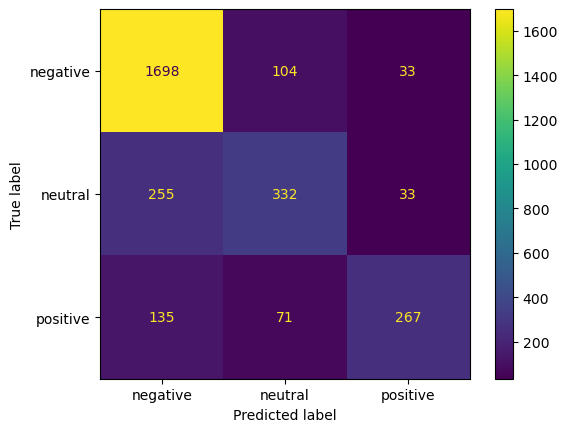

In [54]:
cm = confusion_matrix(y_test, pred, labels=best_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_svc.classes_)
disp.plot();

Support vector classifier showed a little worse general accuracy compared to logistic regression (78 % vs 80 %), however it performed better at classifying negative tweets.

### Conclusions

- Vader lexicon was more accurate for airline sentiment classification than TextBlob lexicons, however they both produced unsatisfactory results.
- For both lexicons the easiest task was recognizing positive tweets.
- Machine learning classification algorithms with vectorized text performed better than lexicons.
- Logistic regression and support vector classifier produced best classification results with logistic regression having best general accuracy and SVC being the best at recognizing negative tweets.

#### Possible improvements

- Improve text cleaning, e.g. leave airline name in the tweet.
- Use same (test) dataset for ML models and lexicons comparison.
- Change more parameter values for classification models.